# --- CHECK COMPLETE ---

## Conexión a drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%ls

drive/  sample_data/


In [4]:
#  !!!! ES NECESARIO EDITAR CON EL PATH CORRESPONDIENTE  !!!!
%cd drive/MyDrive/'Colab Notebooks/TTT-2020-1-16'

/content/drive/MyDrive/Colab Notebooks/TTT-2020-1-16


In [5]:
%pwd

'/content/drive/MyDrive/Colab Notebooks/TTT-2020-1-16'

## Importar los módulos *_utils

In [6]:
import sys
#  !!!! ES NECESARIO EDITAR CON EL PATH CORRESPONDIENTE  !!!!
sys.path.append('/content/drive/My Drive/Colab Notebooks/TTT-2020-1-16')
from my_utils import dataset_utils
from my_utils import eval_utils
from my_utils import nn_utils
from my_utils import results_utils

In [7]:
import pickle

# Ajustes iniciales

# Funciones locales

## Prototipos de modelo

The requirements to use the cuDNN implementation are:

1. activation == tanh
2. recurrent_activation == sigmoid
3. recurrent_dropout == 0
4. unroll is False
5. use_bias is True
6. Inputs, if use masking, are strictly right-padded.
7. Eager execution is enabled in the outermost context.

Check: KERAS docs [https://keras.io/api/layers/recurrent_layers/lstm/]



### biLSTM

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def bidirectionalLSTM_NetModel(task, params, optimizer, verbose = False):
  """
  Defines and compiles a new Keras model for a Convolutional Neural Network

  """

  SEQ_LENGTH = 55
  VEC_EMBEDDINGS_DIM = 300

  units_lstm = params['units_lstm']
  merge_mode = params['merge_mode']
  units_DL1, units_DL2 = params['dense_layers_sizes']

  lstm_dropout  = params['lstm_dropout']
  dense_dropout = params['dense_dropout']


  embedding_sequences_input = keras.Input(name='INPUT',
                                          shape=(SEQ_LENGTH, VEC_EMBEDDINGS_DIM), 
                                          dtype="float64")
  
  LSTM_layer    = layers.LSTM(units=units_lstm, dropout=lstm_dropout, recurrent_dropout=0, return_sequences=False, name='LSTM')
  BiLSTM_layer  = layers.Bidirectional(LSTM_layer, merge_mode, name='BI-LSTM')

  lstm_output = BiLSTM_layer(embedding_sequences_input)
  
  fc_layer_1 = layers.Dense(units_DL1, activation="relu", name = 'DL_1')(lstm_output)
  fc_layer_1 = layers.Dropout(dense_dropout, name = 'DROP_1')(fc_layer_1)
  fc_layer_2 = layers.Dense(units_DL2, activation="relu", name = 'DL_2')(fc_layer_1)
  fc_layer_2 = layers.Dropout(dense_dropout/2, name = 'DROP_2')(fc_layer_2)

  if task in ['HS', 'TR', 'AG']:
    preds = layers.Dense(1, activation="sigmoid", name = 'PREDICTOR')(fc_layer_2)
    model = keras.Model(embedding_sequences_input, preds)

    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])

  elif task == 'HTA':
    preds = layers.Dense(5, activation="softmax", name = 'PREDICTOR')(fc_layer_2)
    preds = reshape = layers.Reshape(target_shape=(5,))(preds)

    model = keras.Model(embedding_sequences_input, preds)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc"])

  if verbose:
    model.summary()

  return model

## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['TR'],
                                                 n_folds=7)

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


# Bloque 1 (optimizers)

## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

dense_layers_sizes = [(450,100),
                      (400,75)]  

arch_params = {'units_lstm':[100,200,300],
          'dense_layers_sizes': dense_layers_sizes,
          'merge_mode':['concat'],
          'lstm_dropout':[0.5],                      
          'dense_dropout':[0.5]}

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

6 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-3', 'adam-5e-4', 'adam-1e-4', 'rmsprop-1e-3', 'rmsprop-5e-4', 'rmsprop-1e-4'],
                       'batch_size':[256,512,1024],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


18 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


108 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'TR',
                          bidirectionalLSTM_NetModel, 
                          search_space[],
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/BiLSTM/TR/experiments_1.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)

## mean time per run = 3 min (partial evaluation)                          

## Resultados

In [ ]:
import pickle
with open('./Results/BiLSTM/TR/experiments_1.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

In [ ]:
results_df.sort_values(by='val_acc_A', ascending=False).head()

In [ ]:
results_df.sort_values(by='val_acc_B', ascending=False).head()

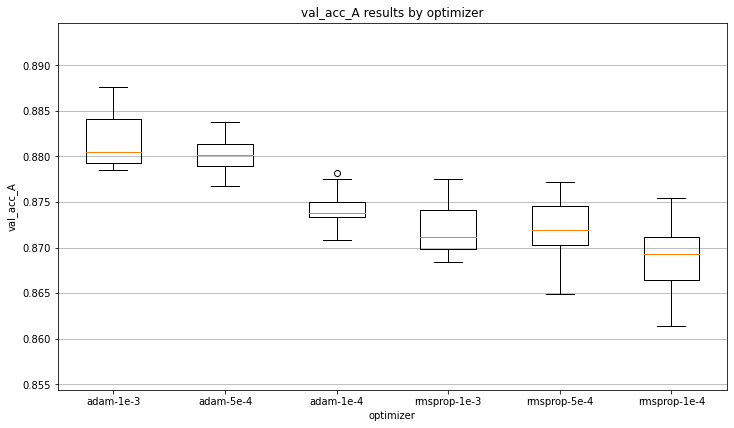

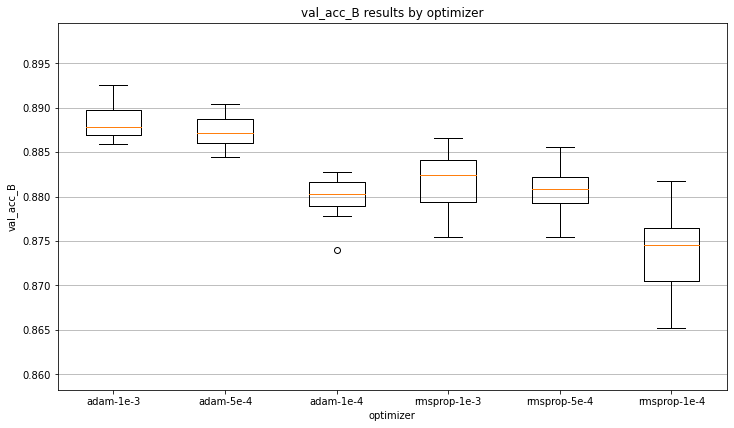

In [ ]:
params_dict = {'optimizer':['adam-1e-3', 'adam-5e-4', 'adam-1e-4', 
                            'rmsprop-1e-3', 'rmsprop-5e-4', 'rmsprop-1e-4']                                
}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['optimizer'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['optimizer'],
                       metric='val_acc_B')

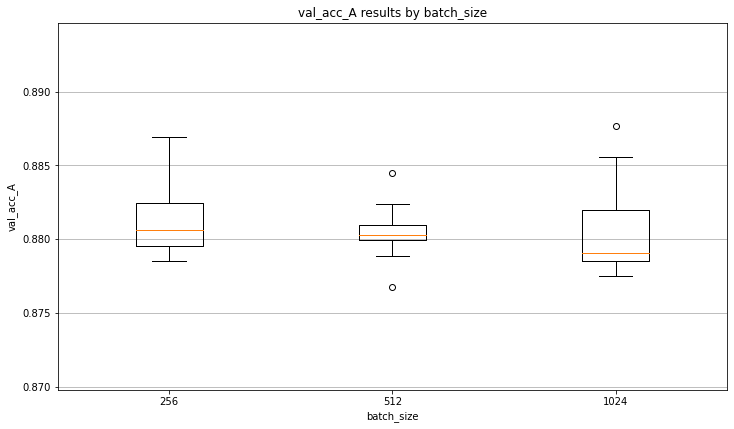

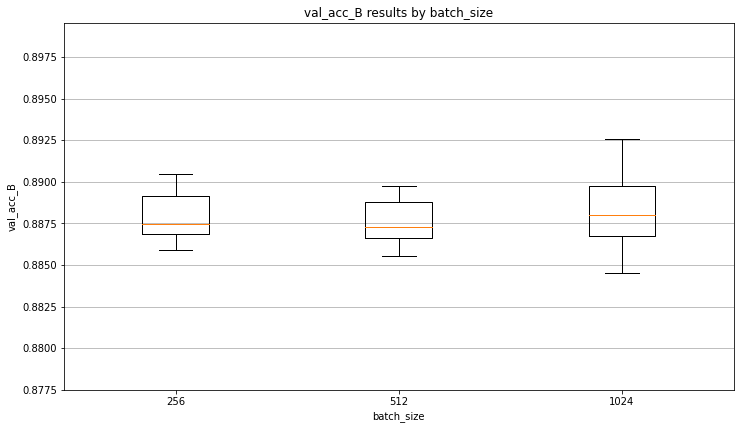

In [ ]:
optimizer_mask = results_df['optimizer'].isin(['adam-1e-3','adam-5e-4'])

results_utils.plotResultsByParameter1(results_df.loc[optimizer_mask], 
                       {'batch_size':[256,512,1024]}, 
                       params2plot=['batch_size'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df.loc[optimizer_mask], 
                       {'batch_size':[256,512,1024]}, 
                       params2plot=['batch_size'],
                       metric='val_acc_B')                       

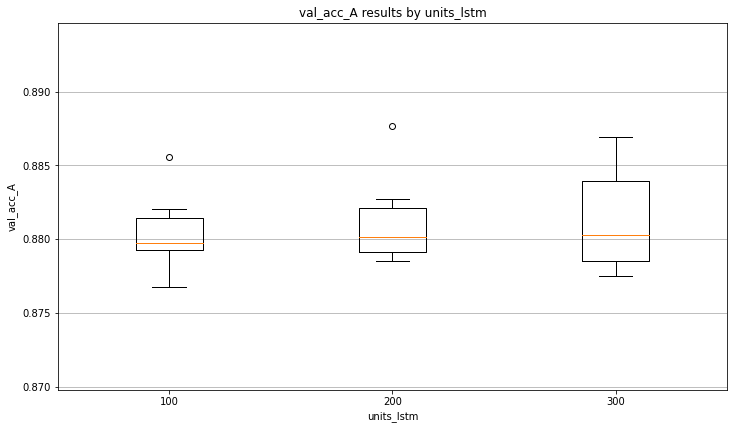

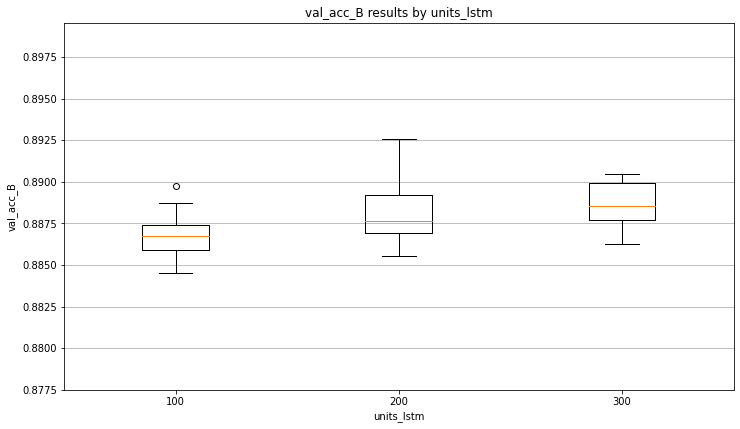

In [ ]:
params_dict = {'units_lstm':[100,200,300]}

results_utils.plotResultsByParameter1(results_df.loc[optimizer_mask], 
                       params_dict, 
                       params2plot=['units_lstm'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df.loc[optimizer_mask], 
                       params_dict, 
                       params2plot=['units_lstm'],
                       metric='val_acc_B')                       

### Resumen de los resultados (checked)

* lstm_units: [200,-300-]

* optimizador: [**'adam-1e-3'**, 'adam-5e-4']
* batch_size: [256, 1024]

# Bloque 2 (lstm_units + dense_layers_sizes)

## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

dense_layers_sizes = [(400,100),
                      (400,75), 
                      (300,100),
                      (300,75),
                      (200,100),
                      (200,75)]  

arch_params = {'units_lstm':[150,200,250,300],
          'dense_layers_sizes': dense_layers_sizes,
          'merge_mode':['concat'],
          'lstm_dropout':[0.5],                      
          'dense_dropout':[0.5]}

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

24 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-3'],
                       'batch_size':[256, 1024],
                       'max_epochs':[75]}

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


2 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


48 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'TR',
                          bidirectionalLSTM_NetModel, 
                          search_space[:],
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/BiLSTM/TR/experiments_2.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)

## Resultados

In [ ]:
import pickle
with open('./Results/BiLSTM/TR/experiments_2.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

results_df.shape

(48, 17)

In [ ]:
results_df.sort_values(by='val_acc_A', ascending=False).head(5)

In [ ]:
results_df.sort_values(by='val_acc_B', ascending=False).head()

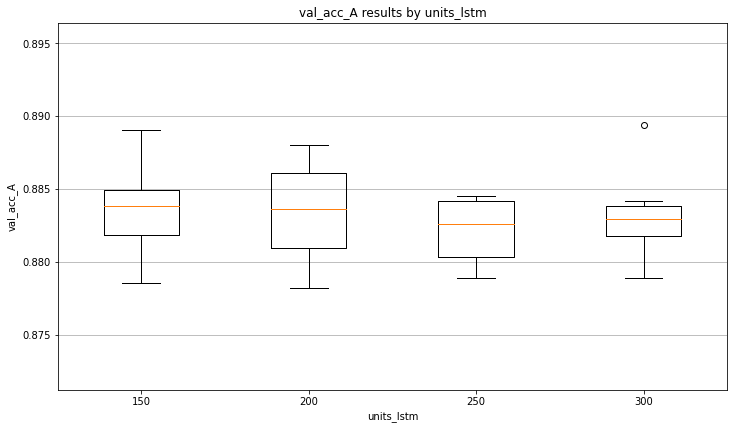

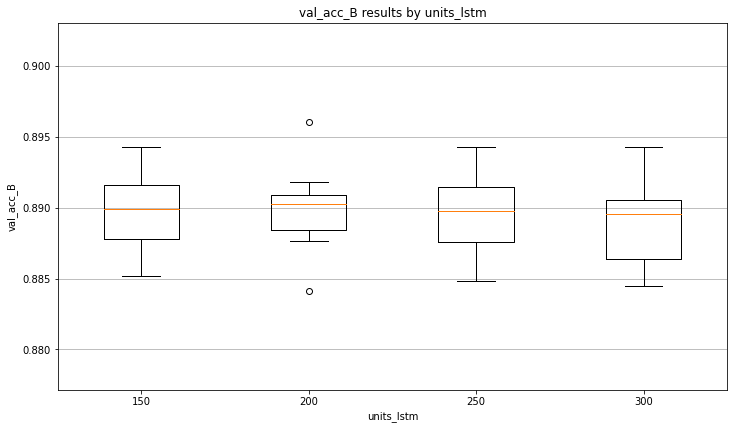

In [ ]:
params_dict = {'units_lstm':[150,200,250,300]}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['units_lstm'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['units_lstm'],
                       metric='val_acc_B')

In [ ]:
units_lstm_mask = results_df['units_lstm'].isin([150,200])

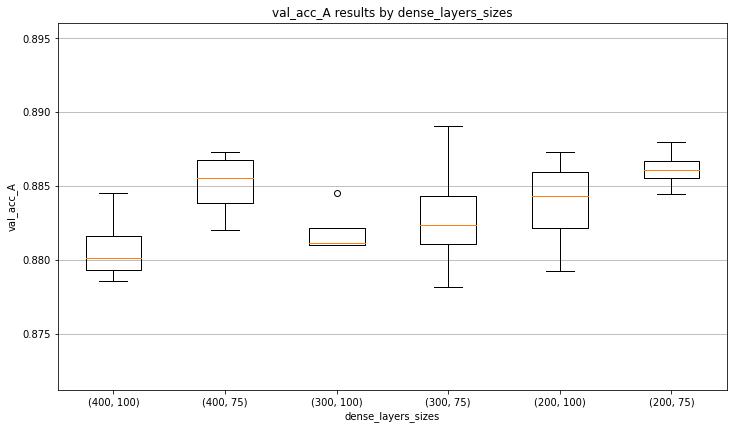

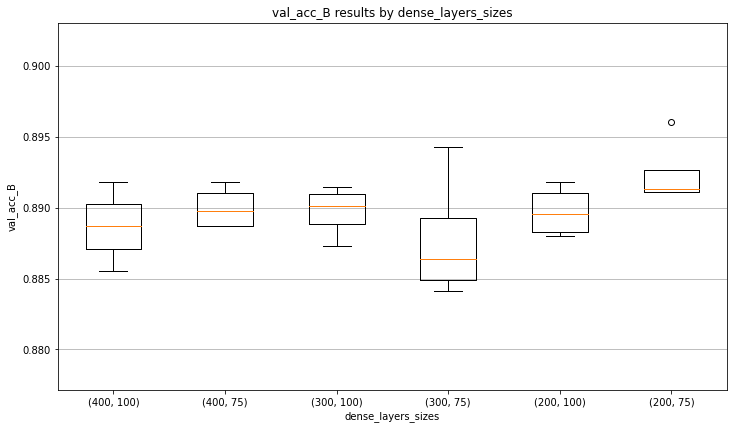

In [ ]:
params_dict = {'dense_layers_sizes':[(400,100),
                      (400,75), 
                      (300,100),
                      (300,75),
                      (200,100),
                      (200,75)] }
                      
results_utils.plotResultsByParameter1(results_df[units_lstm_mask], 
                       params_dict, 
                       params2plot=['dense_layers_sizes'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df[units_lstm_mask], 
                       params_dict, 
                       params2plot=['dense_layers_sizes'],
                       metric='val_acc_B')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


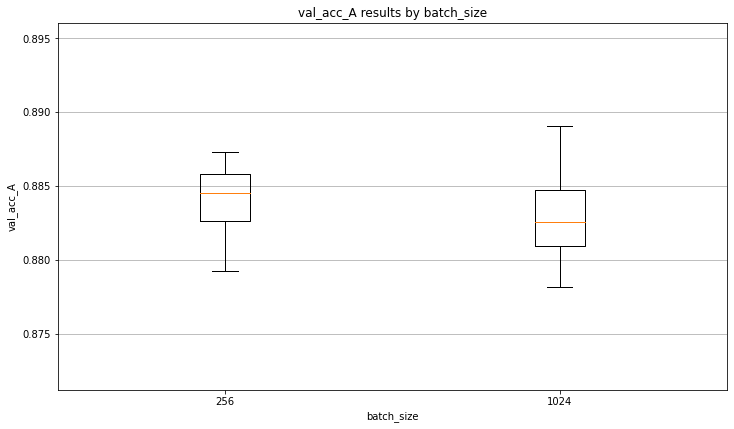

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


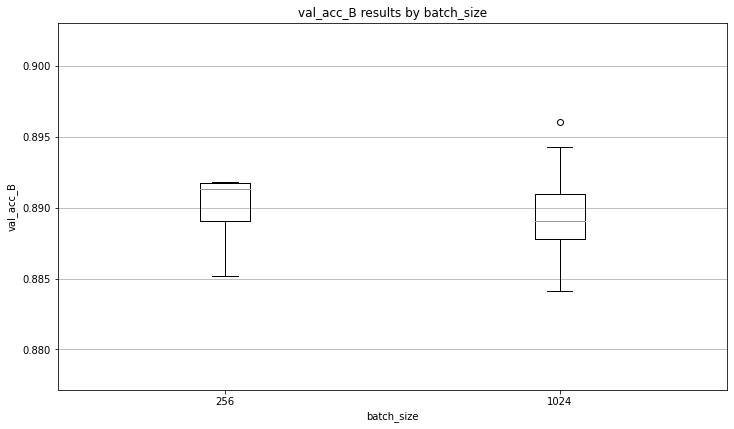

In [ ]:
results_utils.plotResultsByParameter1(results_df.loc[units_lstm_mask], 
                       {'batch_size':[256,1024]}, 
                       params2plot=['batch_size'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df.loc[units_lstm_mask], 
                       {'batch_size':[256,1024]}, 
                       params2plot=['batch_size'],
                       metric='val_acc_B')  

### Resumen de los resultados (checked)

* lstm_units: [**150**, 200]
* dense_layers_sizes: [**(400,75), (200,75)**, (300,75)]


* optimizador: [**'adam-1e-3'**, 'adam-5e-4']
* batch-size: [256, 1024]

# Bloque 3 (dropout)


## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

# For methos A experiments
dense_layers_sizes = [(400,75),
                      (200,75)]  

arch_params = {'units_lstm':[150],
          'dense_layers_sizes': dense_layers_sizes,
          'merge_mode':['concat'],
          'lstm_dropout':[0.3,0.5,0.7],                      
          'dense_dropout':[0.3,0.5,0.7]}

arch_params_combos  = list(product( *arch_params.values() )) 
arch_params_keys = arch_params.keys()        

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

18 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-3'],
                       'batch_size':[256, 1024],
                       'max_epochs':[75]}
                        
training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


2 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


36 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'TR',
                          bidirectionalLSTM_NetModel, 
                          search_space[:],
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/BiLSTM/TR/experiments_3.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)

## Resultados

In [ ]:
import pickle
with open('./Results/BiLSTM/TR/experiments_3.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

In [ ]:
results_df.sort_values(by='val_acc_A', ascending=False).head()

In [ ]:
results_df.sort_values(by='val_acc_B', ascending=False).head()

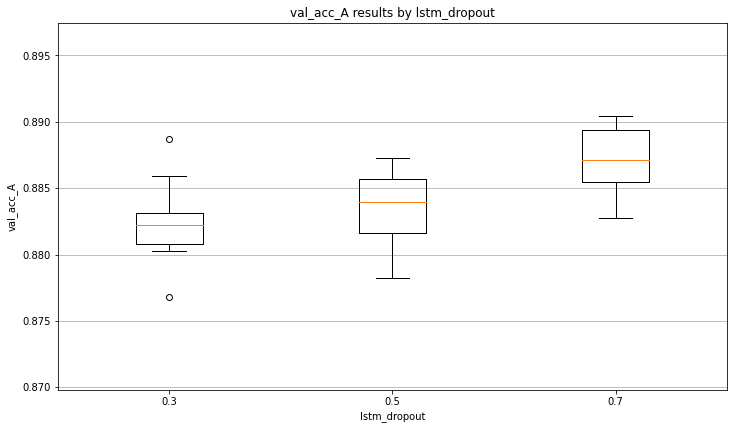

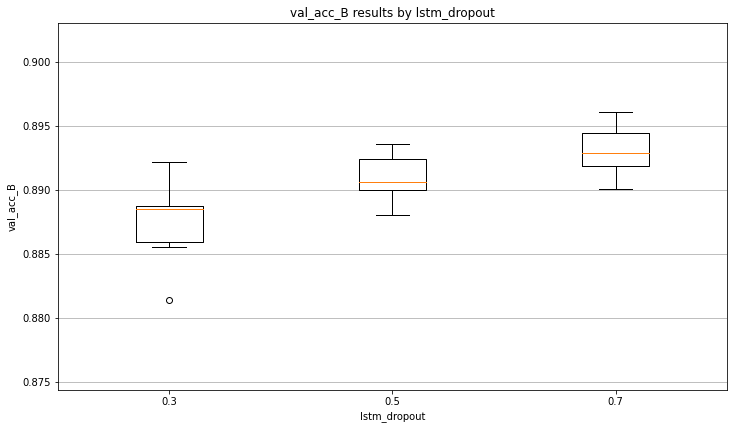

In [ ]:
params_dict = {'lstm_dropout':[0.3,0.5,0.7]}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['lstm_dropout'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['lstm_dropout'],
                       metric='val_acc_B')

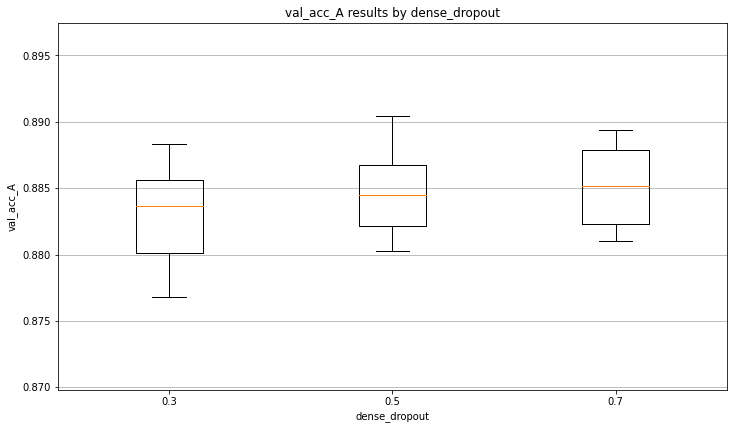

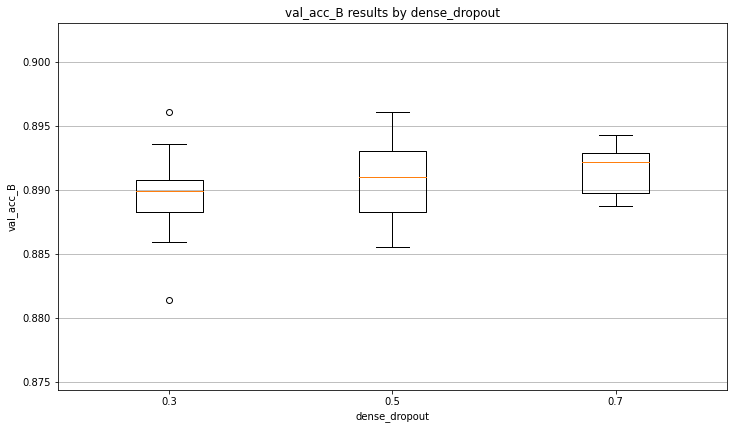

In [ ]:
params_dict = {'dense_dropout':[0.3,0.5,0.7]}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['dense_dropout'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['dense_dropout'],
                       metric='val_acc_B')

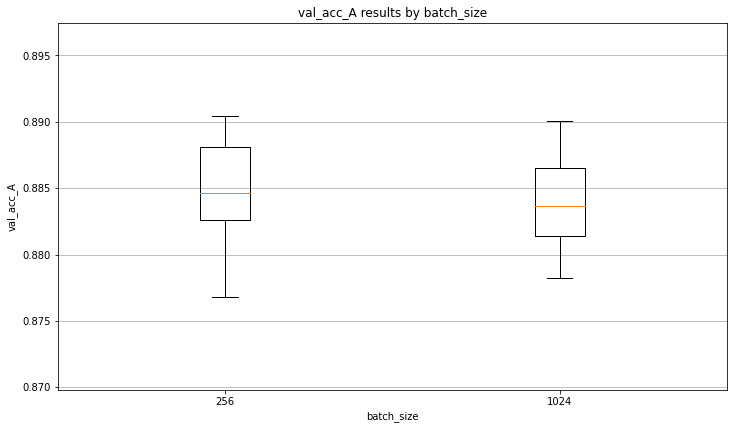

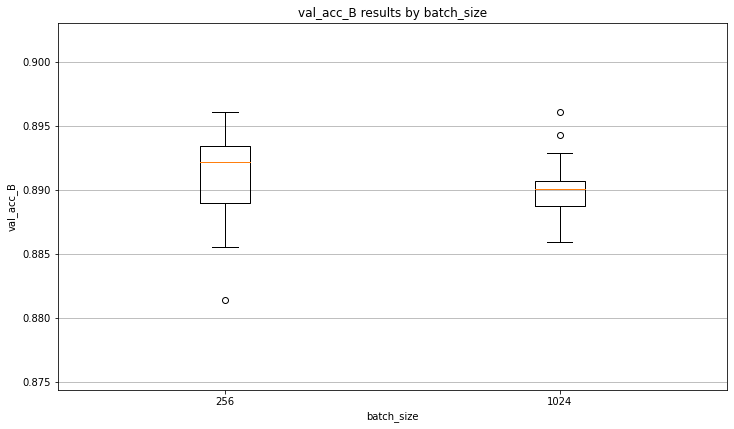

In [ ]:
params_dict = {'batch_size':[256,1024]}  

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['batch_size'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['batch_size'],
                       metric='val_acc_B')

### Resumen de los resultados (checked)

* lstm_units: [**150**,200]
* dense_layers_sizes: [(300,100), (200,100)]
* lstm_dropout: 0.7
* dense dropout: [0.5,0.7]


* optimizador: ['adam-1e-3']
* batch_size [**256**, 1024]

# Bloque 4 (validación completa)

### Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

dense_layers_sizes = [(200,100),
                      (200,75)]  

arch_params = {'units_lstm':[150,200],
          'dense_layers_sizes': dense_layers_sizes,
          'merge_mode':['concat'],
          'lstm_dropout':[0.7],                      
          'dense_dropout':[0.5, 0.7]}

arch_params_combos  = list(product( *arch_params.values() )) 
arch_params_keys = arch_params.keys()        

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

8 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-3'],
                       'batch_size':[256, 1024],
                       'max_epochs':[75]}
                        
training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


2 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


16 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'TR',
                          bidirectionalLSTM_NetModel, 
                          search_space[:16],
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=False,
                          backup_file='./Results/BiLSTM/TR/experiments_4f.df',
                          backup_freq=1,
                          save_history_files=True,
                          save_models_as_json=True,
                          save_weights=True)

## Resultados

In [8]:
import pickle
from pandas import DataFrame

with open('./Results/BiLSTM/TR/experiments_4f.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(16, 17)

In [9]:
search_results.sort_values(by='val_acc_A', ascending=False).head()

,conf_ID,units_lstm,dense_layers_sizes,merge_mode,lstm_dropout,dense_dropout,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,median2best,train_acc_B,val_acc_B
6,qDdrGDRN,150,"(200, 75)",concat,0.7,0.7,adam-1e-3,256,75,21,0.858233,0.892205,13,21,16,0.843899,0.898602
7,zDXbNIXN,150,"(200, 75)",concat,0.7,0.7,adam-1e-3,1024,75,27,0.834534,0.892002,23,50,42,0.853300,0.900202
12,qmWWutWH,200,"(200, 75)",concat,0.7,0.5,adam-1e-3,256,75,16,0.853767,0.891601,10,22,15,0.851867,0.896400
14,nwPtJmRD,200,"(200, 75)",concat,0.7,0.7,adam-1e-3,256,75,15,0.840733,0.891401,10,26,14,0.842434,0.897001
4,UceeXbhf,150,"(200, 75)",concat,0.7,0.5,adam-1e-3,256,75,16,0.852333,0.890802,12,16,14,0.844133,0.895002


In [10]:
search_results.sort_values(by='val_acc_B', ascending=False).head()

,conf_ID,units_lstm,dense_layers_sizes,merge_mode,lstm_dropout,dense_dropout,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,median2best,train_acc_B,val_acc_B
7,zDXbNIXN,150,"(200, 75)",concat,0.7,0.7,adam-1e-3,1024,75,27,0.834534,0.892002,23,50,42,0.853300,0.900202
6,qDdrGDRN,150,"(200, 75)",concat,0.7,0.7,adam-1e-3,256,75,21,0.858233,0.892205,13,21,16,0.843899,0.898602
2,oAsiDtqb,150,"(200, 100)",concat,0.7,0.7,adam-1e-3,256,75,14,0.837233,0.889399,14,30,24,0.863066,0.898000
13,jEHBKuZv,200,"(200, 75)",concat,0.7,0.5,adam-1e-3,1024,75,36,0.855966,0.890198,17,54,33,0.849568,0.898000
5,QXXxwbcD,150,"(200, 75)",concat,0.7,0.5,adam-1e-3,1024,75,34,0.852100,0.889203,25,57,34,0.853400,0.897602
